# Garbage Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import InputLayer, Reshape, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomTranslation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tqdm.keras import TqdmCallback
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%load_ext tensorboard

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregando e separando os dados

In [5]:
!ls "/content/drive/MyDrive/Lucas/Garbage classification"

cardboard  glass  metal  paper	plastic  trash


In [6]:
base_path = '/content/drive/MyDrive/Lucas/Garbage classification'

df_all = pd.DataFrame()
for dirname, _, filenames in os.walk(base_path):
    paths = [dirname + '/' + filename for filename in filenames if '.jpg' in filename]
    folder_name = os.path.split(dirname)[-1]
    df_all = pd.concat([df_all, pd.DataFrame({'path': paths, 'label': folder_name})], ignore_index=True)

df_all

,path,label
0,/content/drive/MyDrive/Lucas/ML/Garbage classi...,cardboard
1,/content/drive/MyDrive/Lucas/ML/Garbage classi...,cardboard
2,/content/drive/MyDrive/Lucas/ML/Garbage classi...,cardboard
3,/content/drive/MyDrive/Lucas/ML/Garbage classi...,cardboard
4,/content/drive/MyDrive/Lucas/ML/Garbage classi...,cardboard
...,...,...
1511,/content/drive/MyDrive/Lucas/ML/Garbage classi...,glass
1512,/content/drive/MyDrive/Lucas/ML/Garbage classi...,glass
1513,/content/drive/MyDrive/Lucas/ML/Garbage classi...,glass
1514,/content/drive/MyDrive/Lucas/ML/Garbage classi...,glass


In [7]:
# Número de imagens por classe (dataset desbalanceado)
df_all['label'].value_counts().sort_index()

cardboard    403
glass        501
metal        410
paper        202
Name: label, dtype: int64

In [8]:
# Número de classes
n_classes = len(df_all['label'].unique())
n_classes

4

In [9]:
# Lista das classes
classes = list(df_all['label'].unique())
classes

['cardboard', 'paper', 'metal', 'glass']

In [10]:
# Reduzindo o dataframe para 125 imagens por classe
df = df_all.head(0)

for c in classes:
  subset = df_all[df_all['label'] == c]
  subset = subset.sample(125, random_state=0)
  df = pd.concat([df, subset], ignore_index=True)

df['label'].value_counts()


cardboard    125
paper        125
metal        125
glass        125
Name: label, dtype: int64

In [11]:
# Separando conjunto de treinamento, validação e teste
df_train, df_test = train_test_split(df, test_size=25*n_classes, stratify=df['label'], random_state=42)
df_train, df_val = train_test_split(df_train, test_size=25*n_classes, stratify=df_train['label'], random_state=42)

df_train_small, _ = train_test_split(df_train, train_size=25*n_classes, stratify=df_train['label'], random_state=42)

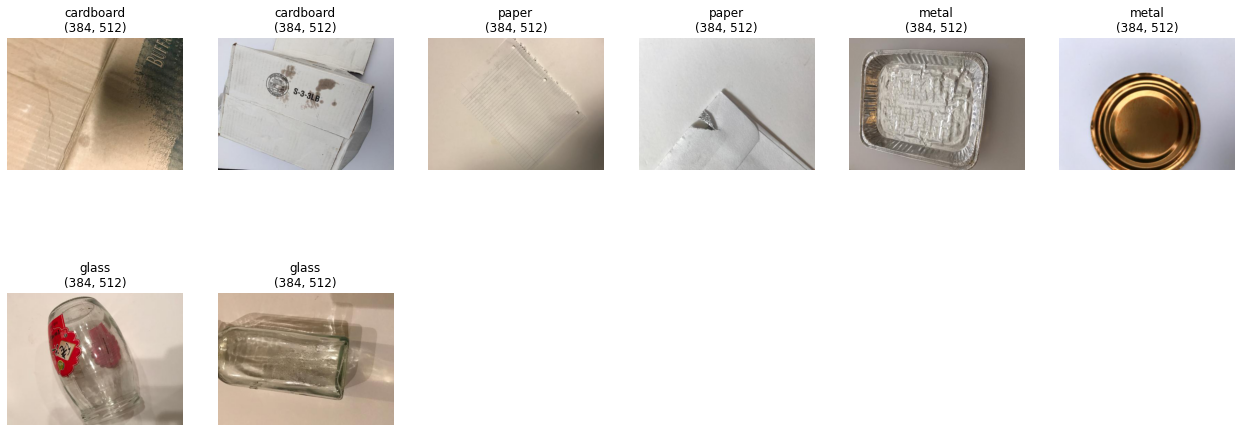

In [12]:
plt.figure(figsize=(22,18))
for i, label in enumerate(classes):
  for j in range(2):
    plt.subplot(4,6, 2*i+j+1)
    img = plt.imread(df_train['path'][df['label'] ==  label].iloc[j])
    plt.imshow(img)
    plt.title(f"{label}\n{img.shape[:2]}")
    plt.axis("off")

In [13]:
# Função para preparar o tf.data.Dataset
try:
    AUTOTUNE = tf.data.AUTOTUNE     
except:
    AUTOTUNE = tf.data.experimental.AUTOTUNE 


def create_dataset(df, img_size, batch_size):
  paths = df['path']
  labels = df['label'].map(classes.index) # ordinal encoder
  ds = tf.data.Dataset.from_tensor_slices((paths, labels))
  ds = ds.map(lambda x, y: (tf.io.read_file(x), y))
  ds = ds.map(lambda x, y: (tf.io.decode_jpeg(x, channels=3), y))
  ds = ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
  ds = ds.cache().batch(batch_size).prefetch(AUTOTUNE)
  return ds

In [14]:
img_size = (80, 80)
batch_size = 64

ds_train_small = create_dataset(df_train_small, img_size, batch_size)
ds_train = create_dataset(df_train, img_size, batch_size)
ds_val = create_dataset(df_val, img_size, batch_size)
ds_test = create_dataset(df_test, img_size, batch_size)

# auxiliar print
print('-'*30)
print('datasets division')
print('-'*30)
print(f'Train (small) = {len(df_train_small)}')
print(f'Train (full) = {len(df_train)}')
print(f'Val = {len(df_val)}')
print(f'Test = {len(df_test)}')

------------------------------
datasets division
------------------------------
Train (small) = 100
Train (full) = 300
Val = 100
Test = 100


## Treinamento com df_train_small


In [ ]:
callbacks = [ReduceLROnPlateau(factor=0.2, patience=10, verbose=0), EarlyStopping(patience=30, verbose=0)]

In [ ]:
def plots(history):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.yscale('log')
  plt.grid(which='both');
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs');
  if 'val_accuracy' in history.keys():
    plt.plot(history['val_accuracy'], '.-', label='Val accuracy')
  plt.legend();
  plt.grid();

### a) Sem a utilização de data augmentation

#### i) Modelo descongelado

In [ ]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_1 = Model(i, x)

model_1.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 80, 80, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 80, 80, 3)        0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                              

0epoch [00:00, ?epoch/s]

CPU times: user 31.1 s, sys: 1.67 s, total: 32.8 s
Wall time: 2min 4s


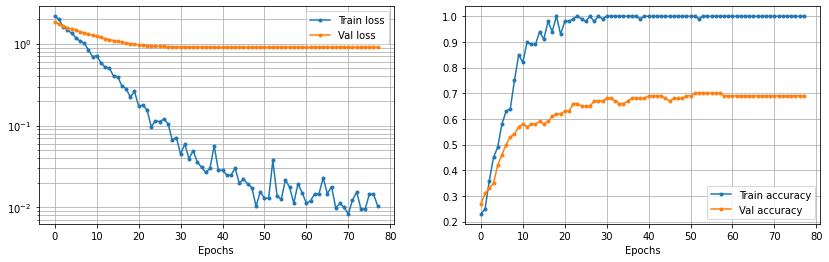

In [ ]:
%%time
epochs = 100
lr = 1e-5

model_1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_1 = model_1.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_1)

#### ii) Modelo congelado

In [ ]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = False

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_2 = Model(i, x)

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1229

0epoch [00:00, ?epoch/s]

CPU times: user 16.6 s, sys: 1.48 s, total: 18.1 s
Wall time: 35.6 s


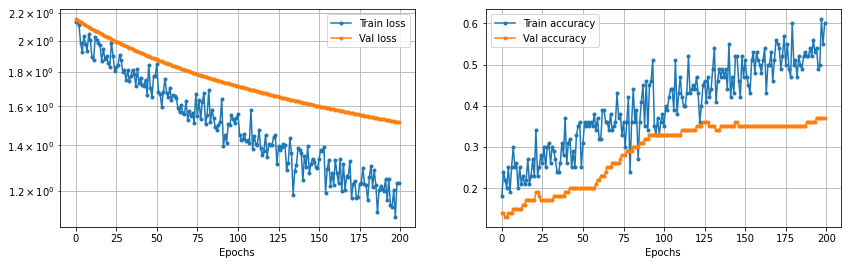

In [ ]:
%%time
epochs = 100
lr = 1e-5
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_2 = model_2.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_2)

#### iii) Fine tuning

0epoch [00:00, ?epoch/s]

CPU times: user 57.2 s, sys: 1.4 s, total: 58.6 s
Wall time: 1min 41s


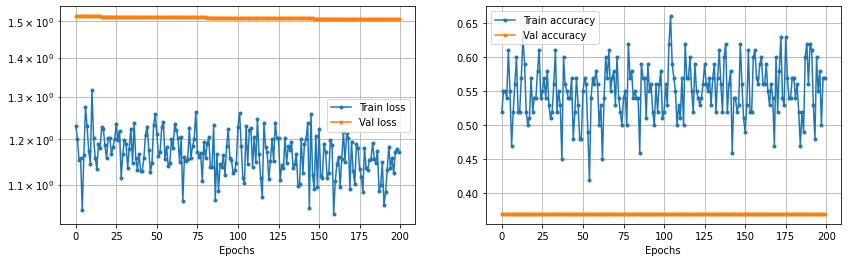

In [ ]:
%%time
base_model.trainable = True

epochs = 100
lr = 1e-8
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_3 = model_2.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_3)

### b) Com a utilização de data augmentation

In [15]:
# Camada de data augmentation
data_augmentation = Sequential(
  [
    RandomTranslation(height_factor=0.15, width_factor=0.15),
    RandomFlip(mode='horizontal')
  ],
  name='data_augmentation',
)

#### i) Modelo descongelado
```



In [ ]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_3 = Model(i, x)

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 80, 80, 3)        0         
 al)                                                             
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                           

0epoch [00:00, ?epoch/s]

CPU times: user 1min 25s, sys: 10.9 s, total: 1min 36s
Wall time: 1min 28s


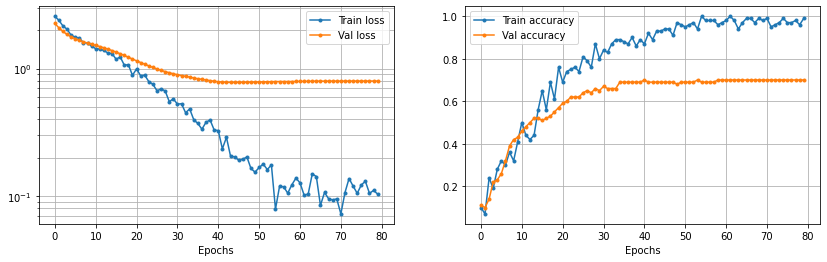

In [ ]:
%%time
epochs = 100
lr = 1e-5

model_3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_4 = model_3.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_4)

#### Modelo congelado

In [ ]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = False

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_4 = Model(i, x)

model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 80, 80, 3)        0         
 al)                                                             
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                           

0epoch [00:00, ?epoch/s]

CPU times: user 2min 38s, sys: 27.7 s, total: 3min 6s
Wall time: 2min 12s


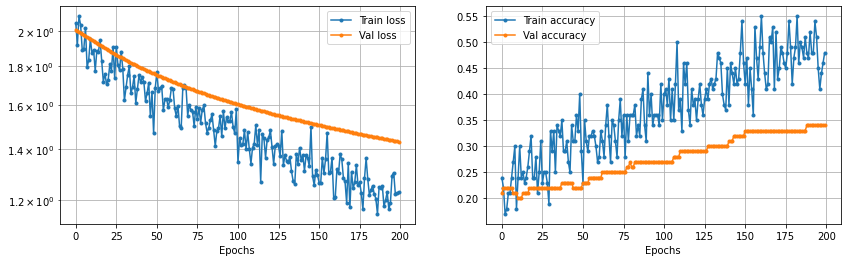

In [ ]:
%%time
epochs = 100
lr = 1e-5

model_4.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_5 = model_4.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_5)

#### Fine tuning

0epoch [00:00, ?epoch/s]

CPU times: user 3min 22s, sys: 27.6 s, total: 3min 50s
Wall time: 3min 25s


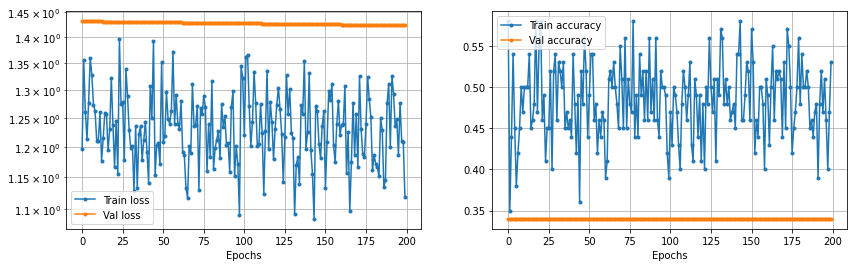

In [ ]:
%%time
base_model.trainable = True

epochs = 100
lr = 1e-8

model_4.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_6 = model_4.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_6)

## Treinamento com dataset de treinamento completo

#### **Baseline**

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 80, 80, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 80, 80, 3)        0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 6)                 12294 

0epoch [00:00, ?epoch/s]

CPU times: user 37.1 s, sys: 745 ms, total: 37.9 s
Wall time: 2min 8s


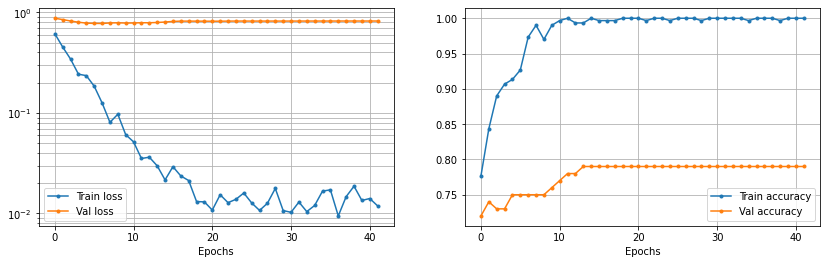

In [ ]:
%%time
epochs = 100
lr = 1e-5

model_1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_7 = model_1.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_7)

#### Data augmentation

In [ ]:
model_3

0epoch [00:00, ?epoch/s]

CPU times: user 2min 27s, sys: 21.1 s, total: 2min 48s
Wall time: 2min 2s


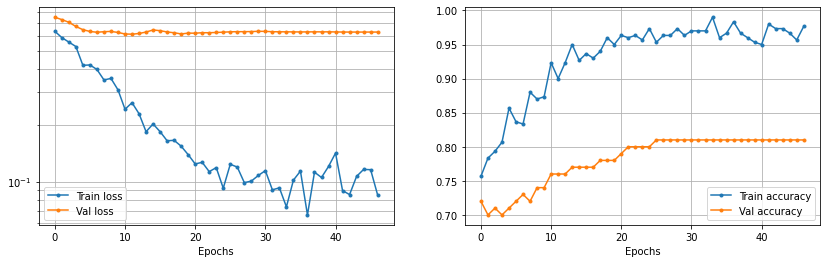

In [ ]:
%%time
epochs = 100
lr = 1e-5

model_3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_8 = model_3.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_8)

#### Alteração do tamanho da imagem

In [16]:
new_img_size = (200, 200)
batch_size = 64

ds_train_r = create_dataset(df_train, new_img_size, batch_size)
ds_val_r = create_dataset(df_val, new_img_size, batch_size)
ds_test_r = create_dataset(df_test, new_img_size, batch_size)

In [17]:
input_shape = new_img_size + (3,) # (150, 150, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_5 = Model(i, x)

model_5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 200, 200, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 200, 200, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 6)                 12294 

0epoch [00:00, ?epoch/s]

CPU times: user 6min 8s, sys: 4.17 s, total: 6min 12s
Wall time: 10min 33s


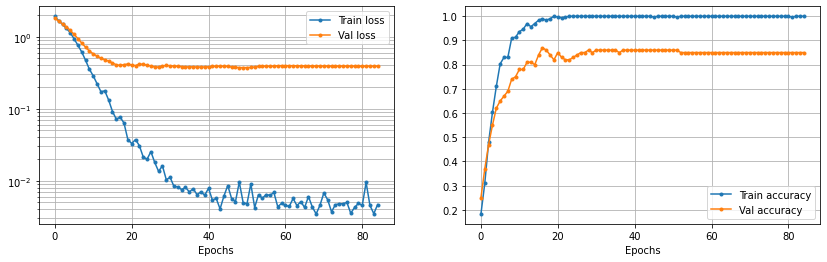

In [ ]:
%%time
epochs = 100
lr = 1e-5

model_5.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_9 = model_5.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_9)

#### ResNet

In [ ]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_6 = Model(i, x)

model_6.summary()

219055592/219055592 [==============================] - 10s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 1536)              0 

0epoch [00:00, ?epoch/s]

CPU times: user 1min 3s, sys: 3.87 s, total: 1min 7s
Wall time: 1min 21s


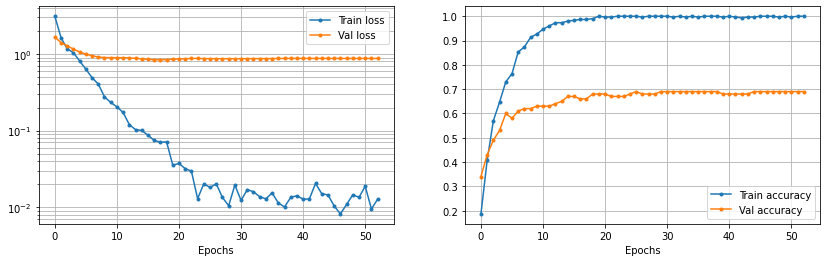

In [ ]:
%%time
epochs = 100
lr = 1e-5

model_6.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_10 = model_6.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_10)

#### Data augmentation + alteração no tamanho da imagem

In [19]:
input_shape = new_img_size + (3,) # (200, 200, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_7 = Model(i, x)

model_7.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 200, 200, 3)      0         
 al)                                                             
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                           

In [38]:
%%time
epochs = 100
lr = 1e-5

model_7.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_11 = model_7.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_11)

0epoch [00:00, ?epoch/s]

KeyboardInterrupt: ignored

#### Data augmentation + Resnet

In [39]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_8 = Model(i, x)

model_8.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                     

In [ ]:
%%time
epochs = 100
lr = 1e-5
model_8.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_12 = model_8.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_12)

#### Alteração no tamanho da imagem + ResNet

In [ ]:
input_shape = new_img_size + (3,) # (200, 200, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_9 = Model(i, x)

model_9.summary()

In [ ]:
%%time
epochs = 100
lr = 1e-5

model_9.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_13 = model_9.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_13)

#### Data augmentation + alteração no tamanho da imagem + ResNet

In [ ]:
input_shape = new_img_size + (3,) # (200, 200, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_10 = Model(i, x)

model_10.summary()

In [ ]:
%%time
epochs = 100
lr = 1e-5

model_10.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_14 = model_10.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_14)

## Retreinamento (train + val)

In [ ]:
# Dataset de treinamento + val
ds_retr = create_dataset(pd.concat([df_train, df_val], ignore_index=True), new_img_size, batch_size)

In [ ]:
# Melhor modelo: data augmentation + alteração no tamanho da imagem (utilizando Xception) - "model_7"
%%time

epochs = 100
lr = 1e-5

model_7.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_retr = model_7.fit(ds_retr, epochs=epochs, callbacks=[TqdmCallback(verbose=0)], verbose=0)

plots(history_retr)

## Análise de resultados (test)

### Matriz de confusão (test)


In [20]:
# Predição das imagens com o melhor modelo - "model-7"
test_pred = model_7.predict(ds_test_r) 

2/2 [==============================] - 29s 7s/step


In [21]:
# Valores reais
test_true = df_test['label']

In [24]:
# Transformando as probabilidades preditos para comparar com as labels do df_test
input_array = np.argmax(test_pred, axis=1)
rows = len(input_array)
classified_list = [None]*rows

for i in range(rows):
  classified_list[i] = classes[input_array[i]]

IndexError: ignored

In [ ]:
cm = confusion_matrix(test_true, test_pred)

display = ConfusionMatrixDisplay(cm, display_labels=classes)
display.plot(cmap=plt.cm.Blues)
plt.show()

### Classificações erradas (test)

In [ ]:
df_results = pd.dataframe({'Imagem real': test_true, 'Predicão': classified_list, 'Predição_Correta': (test_true == classified_list)})
df_results.head(15)

####